# Analyze Benchmarking Results for Document Storage Engine

In [1]:
import os.path
import json
import re
from glob import glob
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import csaps

plt.style.use(['fivethirtyeight'])
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 400)
pd.set_option('display.max_colwidth', 100)

colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]

# Constants

In [2]:
background_color = '#fcfcfc'
old_background_color = plt.rcParams['axes.edgecolor']
for k,v in plt.rcParams.items():
    if v == old_background_color:
        plt.rcParams[k] = background_color

In [3]:
results_base_dir = 'results/doc'
!ls $results_base_dir

get  get_initial  initial  initial_c5d.9xlarge	line_lens.txt  load  update


In [4]:
figdir = 'figures/doc'
!rm -r $figdir
!mkdir -p $figdir

# Utilities

In [5]:
def read_results(directory, name_attr_extractor):
    results = []
    for path in glob(results_base_dir + '/' + directory + '/*.jsonl'):
        attrs = name_attr_extractor(os.path.splitext(os.path.basename(path))[0])
        x = pd.read_json(path, lines=True)
        x['time'] = (x['time'] - x['time'].iloc[0]) / 1e9
        attrs['results'] = x
        results.append(attrs)
    return pd.DataFrame(results)

In [6]:
def add_bar_values(ax, x, offset=2):
    for i, v in enumerate(x):
        ax.text(v + offset, i, f'{v:.1f}',
                verticalalignment='center',
                bbox=dict(facecolor=background_color, alpha=1))

In [7]:
def min_duration(df):
    return df.loc[df['duration'].idxmin()]

In [8]:
def compute_rate(results, y_label, dy_dt_label=None, rate=1):
    def row_rate(row):
        row = row.copy()
        x = row['results'][::rate]
        t = np.array(x['time'])
        dt = t[1::] - t[:-1:]
        y = np.array(x[y_label])
        dy = y[1::] - y[:-1:]
        dy_dt = dy/dt
        row['results'] = pd.concat([pd.Series(t[1::]).rename('time'),
                                    pd.Series(dy_dt).rename(dy_dt_label or y_label)], axis=1)
        return row
    return results.apply(row_rate, axis=1)

In [9]:
def time_plot(results, y_col, label_func, t_scale=1.0/60.0, y_scale=1, rate=1, ax=None, spline=True):
    if ax is None:
        fig = plt.figure(figsize=(9,7))
        ax = fig.add_subplot(111)
    for color,(index, row) in zip(colors, results.iterrows()):
        x = row['results'].iloc[1::rate]
        t = x['time'] * t_scale
        y = x[y_col] * y_scale
        if spline:
            ax.plot(t, y, 'o', color=color, alpha=0.3, ms=8, zorder=1, mec='k')
            ts = np.linspace(t.min(), t.max(), 200)
            ys = csaps.csaps(t, y, ts, smooth=0.9)
            ax.plot(ts, ys, '-', color=color, lw=10, alpha=0.75, zorder=2, label=label_func(index, row))
            ax.plot(ts, ys, '-', color='k', lw=1, alpha=1, zorder=3)
        else:
            ax.plot(t, y, 'o', color=color, alpha=0.7, ms=8, zorder=1,
                    label=label_func(index, row))
            ax.plot(t, y, '-', color='k', lw=1, alpha=1, zorder=3)



In [10]:
def savefig(name, fig=None):
    (fig or plt.gcf()).savefig(f'{figdir}/{name}.png', bbox_inches='tight')

# Analyzing JSON Data

In [11]:
line_lens = pd.read_csv('results/doc/line_lens.txt', sep=' ', names=['len', 'count'], header=None)
line_lens['len'] -= 1 # drop newline
line_lens.head()

,len,count
0,919,3
1,920,5
2,921,7
3,922,27
4,923,97


In [12]:
entries = line_lens['count'].sum()
f'{entries:.2e}'

'1.47e+08'

In [13]:
total_json_size = (line_lens['len'] * line_lens['count']).sum()
f'{total_json_size/1e9:.2f}'

'185.86'

In [14]:
avg_entry_len = round(total_json_size / entries, 1)
avg_entry_len

1265.6

In [15]:
line_lens['cum_frac'] = line_lens['count'].cumsum() / line_lens['count'].sum()

In [16]:
line_lens['cum_perc'] = line_lens['cum_frac'] * 100

In [17]:
percentiles = pd.DataFrame([{'percentile':round(100*f, 1),
                            'len': line_lens['len'][line_lens['cum_frac'] >= f].iloc[0]}
                           for f in [0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 1.0]]
                            )

perc_show = percentiles.copy().rename(
    columns={'len': 'Length Bytes', 'percentile': 'Percentile %'}).set_index('Percentile %')
perc_show['Length Bytes'] = perc_show['Length Bytes'].map('{:,}'.format)
perc_show = perc_show.T
print(' '.join(perc_show.to_html(index=True).split()))

perc_show

<table border="1" class="dataframe"> <thead> <tr style="text-align: right;"> <th>Percentile %</th> <th>0.0</th> <th>25.0</th> <th>50.0</th> <th>75.0</th> <th>90.0</th> <th>95.0</th> <th>99.0</th> <th>99.9</th> <th>100.0</th> </tr> </thead> <tbody> <tr> <th>Length Bytes</th> <td>919</td> <td>1,119</td> <td>1,184</td> <td>1,304</td> <td>1,516</td> <td>1,742</td> <td>2,506</td> <td>5,106</td> <td>121,186</td> </tr> </tbody> </table>


Percentile %,0.0,25.0,50.0,75.0,90.0,95.0,99.0,99.9,100.0
Length Bytes,919,"1,119","1,184","1,304","1,516","1,742","2,506","5,106","121,186"


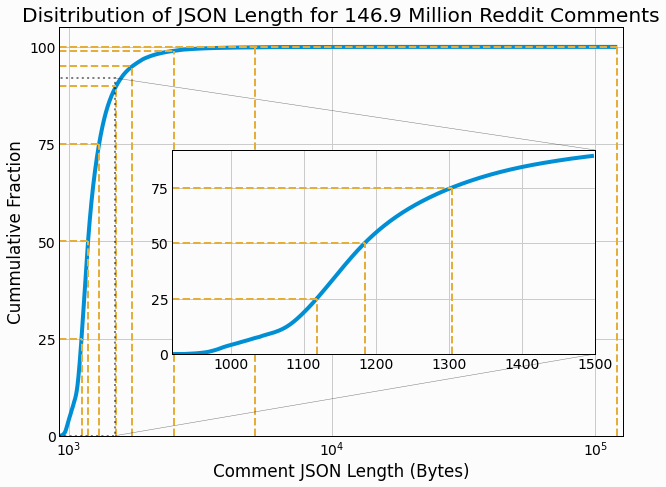

In [18]:

def plot_dist(ax, ll):
    ll.plot('len', 'cum_perc', style='-', ax=ax)
    for _,row in percentiles.iterrows():
        if row['len'] <= ll['len'].max():
            ax.plot([ll['len'].min(), row['len']],
                    [row['percentile'], row['percentile']],
                '--', color=colors[2], lw=2)
            
            ax.plot([row['len'], row['len']],
                    [0, row['percentile']],
                '--', color=colors[2], lw=2)
    
    ax.get_legend().remove()
    ax.set_yticks(np.arange(0, 101, 25))


with plt.rc_context({'axes.edgecolor':'k', 'axes.linewidth':1}):
    fig = plt.figure(figsize=(9,7))
    ax = fig.add_subplot(111)
    plot_dist(ax, line_lens)
    ax.set_xscale('log')
    ax.set_ylim(0, 105)
    ax.set_xlim(line_lens['len'].min(), 1.05 * line_lens['len'].max())

    ax.set_title(f'Disitribution of JSON Length for {entries/1e6:.1f} Million Reddit Comments')
    ax.set_xlabel('Comment JSON Length (Bytes)')
    ax.set_ylabel('Cummulative Fraction')


    axins = ax.inset_axes([0.2, 0.2, 0.75, 0.5])
    plot_dist(axins, line_lens[line_lens['len'] < 1500])
    axins.set_ylim(0, 92)
    axins.set_xlim(line_lens['len'].min(), 1500)

    axins.set_xlabel('')
    ax.indicate_inset_zoom(axins, edgecolor='k', lw=2, ls=':')

savefig('reddit_comment_json_len_dist')

# Analyzing Loading

In [19]:
def extract_load_attrs(name):
    partitions, read_threads, write_threads = map(int, name.split('_'))
    return {'partitions':partitions, 'read_threads':read_threads, 'write_threads':write_threads}

load_results = read_results('load', extract_load_attrs)
load_results.sample(5)

,partitions,read_threads,write_threads,results
5,1,1,1,time writes size 0 0.000000 0 0 1 1...
7,1,1,2,time writes size 0 0.000000 0 0 1 1...
8,4,8,8,time writes size 0 0.000000 0 0 1 1.11113...
9,1,2,1,time writes size 0 0.000000 0 0 1 1...
4,8,8,16,time writes size 0 0.000000 0 0 1 1.15...


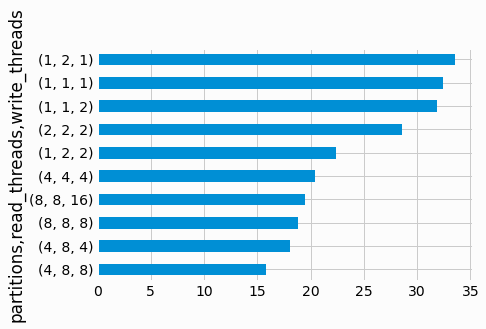

In [20]:
load_results['duration'] = load_results['results'].map(lambda x: x['time'].iloc[-1] - x['time'].iloc[0])
(load_results
 .set_index(['partitions', 'read_threads', 'write_threads'])
 ['duration'].div(60).sort_values()
 .plot.barh())

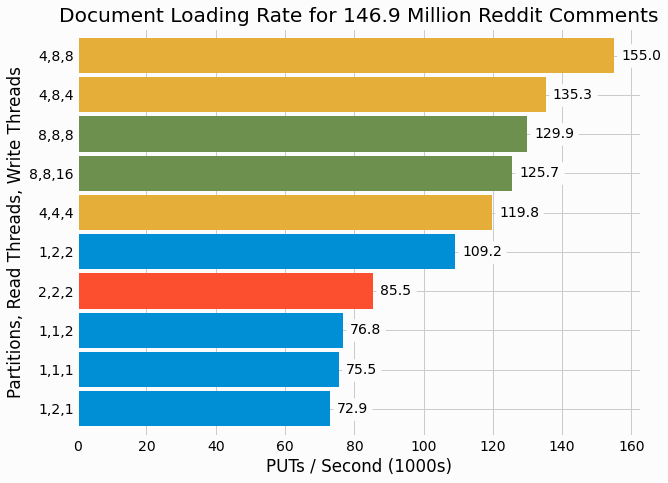

In [21]:
load_results['rate'] = entries / load_results['duration']
x = (load_results
 .set_index(['partitions', 'read_threads', 'write_threads'])
 ['rate'].div(1000).sort_values())
p = x.reset_index()['partitions']
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)
x.plot.barh(color=p.map(dict(zip(sorted(set(p)), colors))), ax=ax, width=0.9)
add_bar_values(ax, x)
ax.set_yticklabels(x.index.map(lambda i: ','.join(map(str, i))))
ax.set_ylabel('Partitions, Read Threads, Write Threads')
ax.set_xlabel('PUTs / Second (1000s)')
ax.set_title(f'Document Loading Rate for {entries/1e6:.1f} Million Reddit Comments')
savefig('doc_load_rate')

In [22]:
load_partition_min_duration = load_results.groupby('partitions').apply(min_duration).drop('partitions', axis=1)

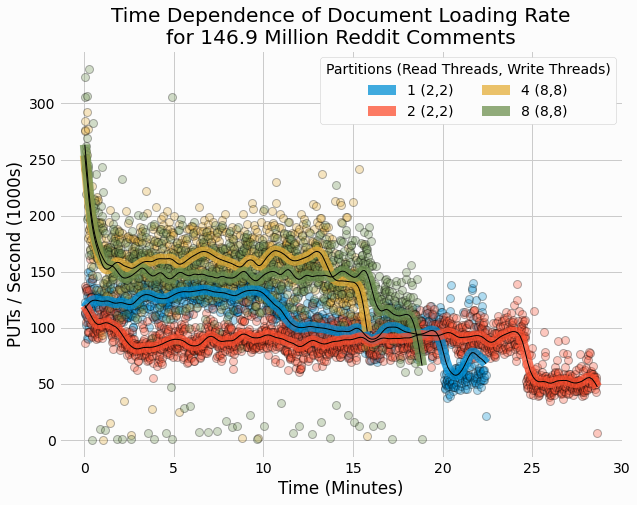

In [23]:
time_plot(compute_rate(load_partition_min_duration, 'writes'), 
          y_col='writes', y_scale=1e-3,
          label_func=lambda partitions, row: f'{partitions} ({row["read_threads"]},{row["write_threads"]})')

plt.ylabel('PUTs / Second (1000s)')
plt.legend(loc='upper right', ncol=2, title='Partitions (Read Threads, Write Threads)', framealpha=1)
plt.xlabel('Time (Minutes)')
plt.title(f'Time Dependence of Document Loading Rate\nfor {entries/1e6:.1f} Million Reddit Comments')
savefig('doc_load_time_dependence')

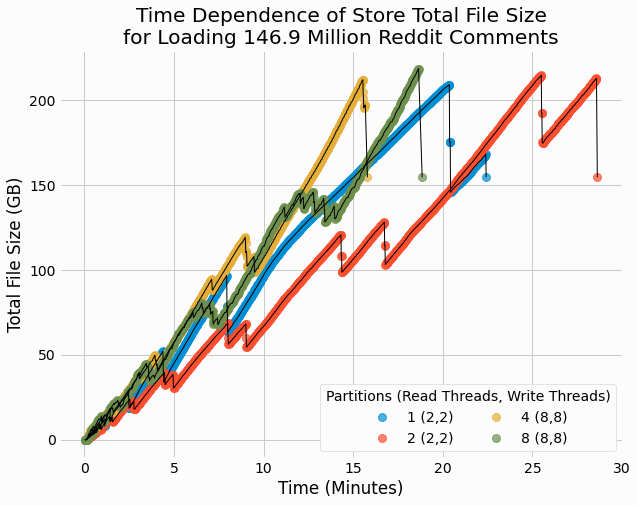

In [24]:
time_plot(load_partition_min_duration, y_col='size', y_scale=1e-9, spline=False,
          label_func=lambda partitions, row: f'{partitions} ({row["read_threads"]},{row["write_threads"]})')

plt.ylabel('Total File Size (GB)')
plt.legend(loc='lower right', ncol=2, title='Partitions (Read Threads, Write Threads)', framealpha=1)
plt.xlabel('Time (Minutes)')
plt.title(f'Time Dependence of Store Total File Size\nfor Loading {entries/1e6:.1f} Million Reddit Comments')
savefig('doc_load_time_dependence_size')

# Analyzing Get

In [25]:
def extract_get_attrs(name):
    partitions, threads = map(int, name.split('_'))
    return {'partitions':partitions, 'threads':threads}

get_results = read_results('get', extract_get_attrs)
get_results.sample(5)

,partitions,threads,results
13,4,32,time gets size 0 0.000000 0 154498682063 1 1.104962 ...
0,8,16,time gets size 0 0.000000 0 154497019784 1 1.157765 ...
14,4,4,time gets size 0 0.000000 0 154498682063 1 1.060584 ...
16,8,80,time gets size 0 0.000000 0 154497019784 1 1.297131 ...
10,8,32,time gets size 0 0.000000 0 154497019784 1 1.109208 ...


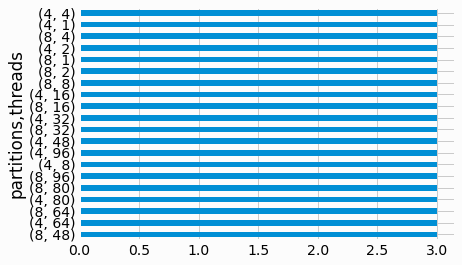

In [26]:
get_results['duration'] = get_results['results'].map(lambda x: x['time'].iloc[-1] - x['time'].iloc[0])
get_results.set_index(['partitions', 'threads'])['duration'].div(60).sort_values(ascending=False).plot.barh()

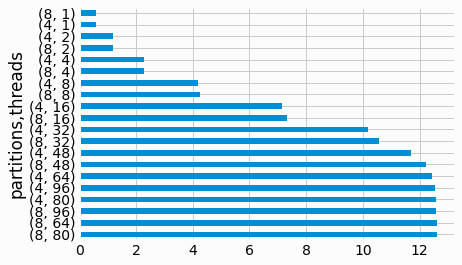

In [27]:
get_results['gets'] = get_results['results'].map(lambda x: x['gets'].iloc[-1])
get_results.set_index(['partitions', 'threads'])['gets'].sort_values(ascending=False).div(1e6).plot.barh()

70.07542851516712

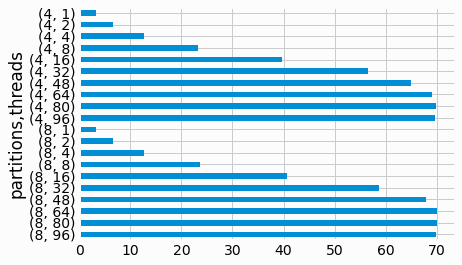

In [28]:
get_results['get_rate'] = get_results['gets'] / get_results['duration']
get_results.set_index(['partitions', 'threads'])['get_rate'].sort_index(ascending=False).div(1e3).plot.barh()
get_results['get_rate'].max() / 1e3

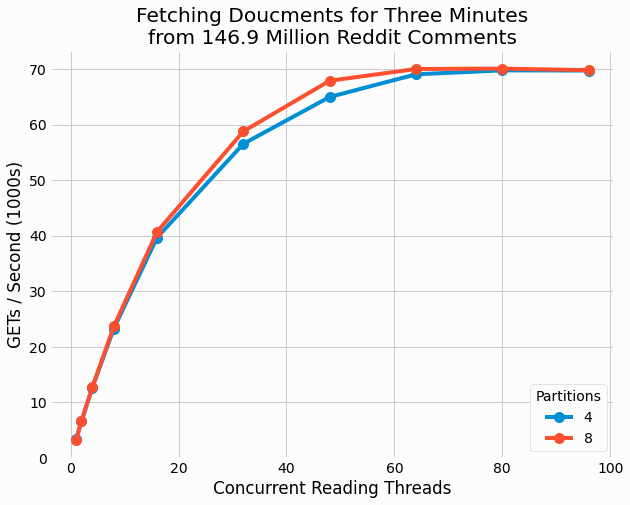

In [29]:
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(1, 1, 1)
for partitions, x in get_results.groupby('partitions'):
    x = x.copy()
    x['get_rate'] /= 1e3
    x.sort_values('threads').plot('threads', 'get_rate', style='o-', label=str(partitions), ax=ax, ms=10)
#plt.xscale('log')
#plt.xticks(x['threads'], x['threads'])
plt.ylabel('GETs / Second (1000s)')
plt.legend(loc='lower right', ncol=1, title='Partitions', framealpha=1)
plt.xlabel('Concurrent Reading Threads')
plt.title(f'Fetching Doucments for Three Minutes\nfrom {entries/1e6:.1f} Million Reddit Comments')
savefig('doc_get_rate')

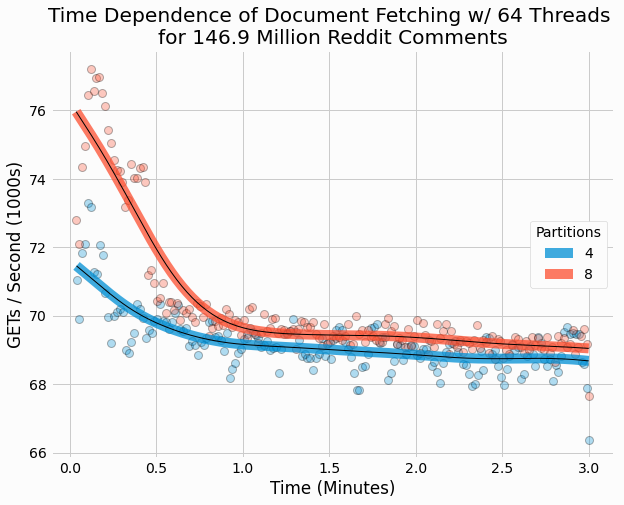

In [30]:
time_plot(compute_rate(get_results[get_results['threads'] == 64], 'gets'), 
          y_col='gets', y_scale=1e-3,
          label_func=lambda ix, row: str(row['partitions']))

plt.ylabel('GETs / Second (1000s)')
plt.legend(loc='center right', ncol=1, title='Partitions', framealpha=1)
plt.xlabel('Time (Minutes)')
plt.title(f'Time Dependence of Document Fetching w/ 64 Threads \nfor {entries/1e6:.1f} Million Reddit Comments')
savefig('doc_get_time_dependence')

# Analyzing Updates

In [31]:
def extract_get_attrs(name):
    partitions, threads = map(int, name.split('_'))
    return {'partitions':partitions, 'threads':threads}

update_results = read_results('update', extract_get_attrs)
update_results.sample(5)

,partitions,threads,results
2,2,80,time updates size 0 0.000000 0 154505206469 1 1.2...
20,8,64,time updates size 0 0.000000 0 154497019784 1 1.2...
6,4,96,time updates size 0 0.000000 0 154498682063 1 1.2...
24,4,8,time updates size 0 0.000000 0 154498682063 1 1.079...
12,2,96,time updates size 0 0.000000 0 154505206469 1 1.2...


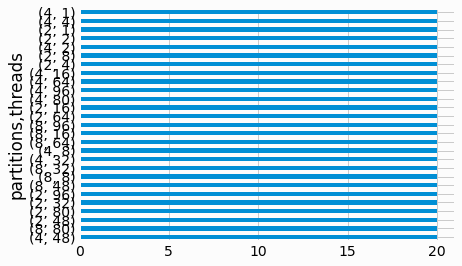

In [32]:
update_results['duration'] = update_results['results'].map(lambda x: x['time'].iloc[-1] - x['time'].iloc[0])
update_results.set_index(['partitions', 'threads'])['duration'].div(60).sort_values(ascending=False).plot.barh()

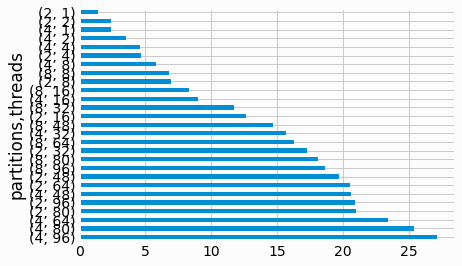

In [33]:
update_results['updates'] = update_results['results'].map(lambda x: x['updates'].iloc[-1])
update_results.set_index(['partitions', 'threads'])['updates'].sort_values(ascending=False).div(1e6).plot.barh()

22.635536270288053

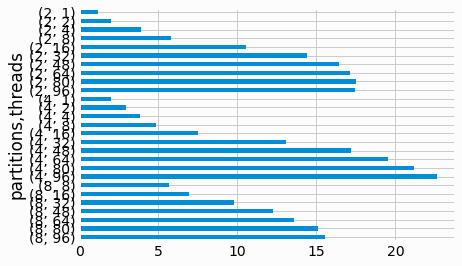

In [34]:
update_results['rate'] = update_results['updates'] / update_results['duration']
update_results.set_index(['partitions', 'threads'])['rate'].sort_index(ascending=False).div(1e3).plot.barh()
update_results.set_index(['partitions', 'threads'])['rate'].max() / 1e3

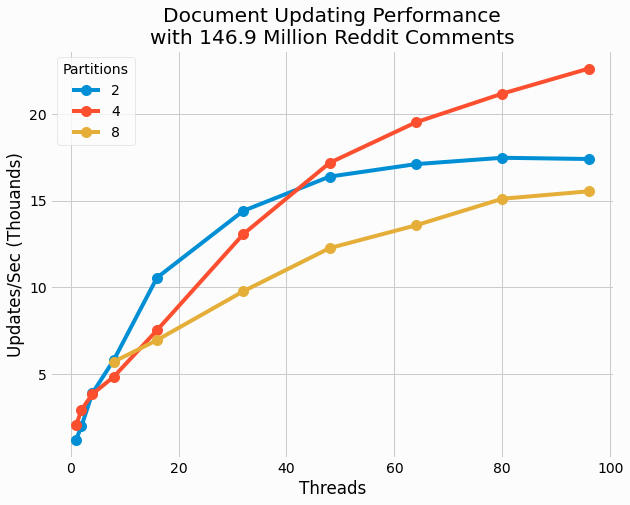

In [35]:
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(1, 1, 1)
for color,(partitions, x) in zip(colors, update_results.groupby('partitions')):
    x = x.sort_values('threads')
    x['rate'] /= 1000
    x.sort_values('threads').plot('threads', 'rate', style='o-', label=str(partitions), ax=ax, ms=10)

ax.legend(title='Partitions')
ax.set_xlabel('Threads')
ax.set_ylabel('Updates/Sec (Thouands)')
plt.title(f'Document Updating Performance\nwith {entries/1e6:.1f} Million Reddit Comments')
savefig('doc_update_rate')
#plt.xscale('log')
#plt.xticks(x['threads'], x['threads'])

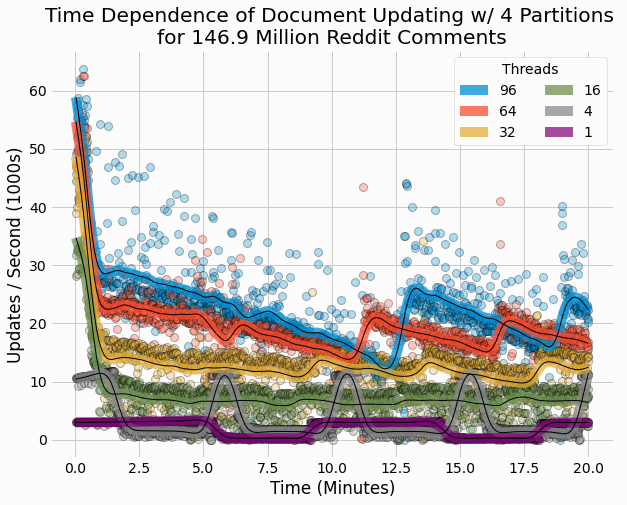

In [36]:
time_plot(compute_rate(update_results[(update_results['threads'].isin([1, 4, 16, 32, 64, 96])) &
                                      (update_results['partitions'] == 4)]
                     .sort_values('threads', ascending=False), 'updates'), 
          y_col='updates', y_scale=1e-3,
          label_func=lambda ix, row: str(row['threads']))

plt.ylabel('Updates / Second (1000s)')
plt.legend(loc='upper right', ncol=2, title='Threads', framealpha=1)
plt.xlabel('Time (Minutes)')
plt.title(f'Time Dependence of Document Updating w/ 4 Partitions \nfor {entries/1e6:.1f} Million Reddit Comments')
savefig('doc_update_time_dependence_threads')


<Figure size 648x504 with 0 Axes>

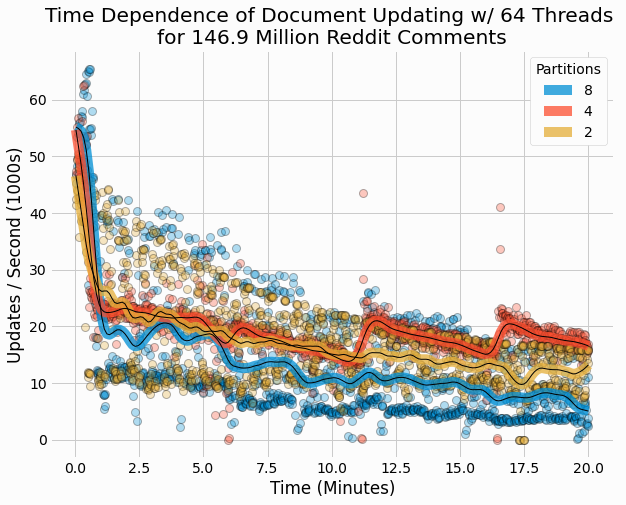

In [37]:
plt.figure(figsize=(9,7))

time_plot(compute_rate(update_results[(update_results['threads'] == 64)]
                       .sort_values('partitions', ascending=False),
                       'updates'), 
          y_col='updates', y_scale=1e-3,
          label_func=lambda ix, row: str(row['partitions']))

plt.ylabel('Updates / Second (1000s)')
plt.legend(loc='upper right', ncol=1, title='Partitions', framealpha=1)
plt.xlabel('Time (Minutes)')
plt.title(f'Time Dependence of Document Updating w/ 64 Threads \nfor {entries/1e6:.1f} Million Reddit Comments')
savefig('doc_update_time_dependence_partitions')


<Figure size 648x504 with 0 Axes>

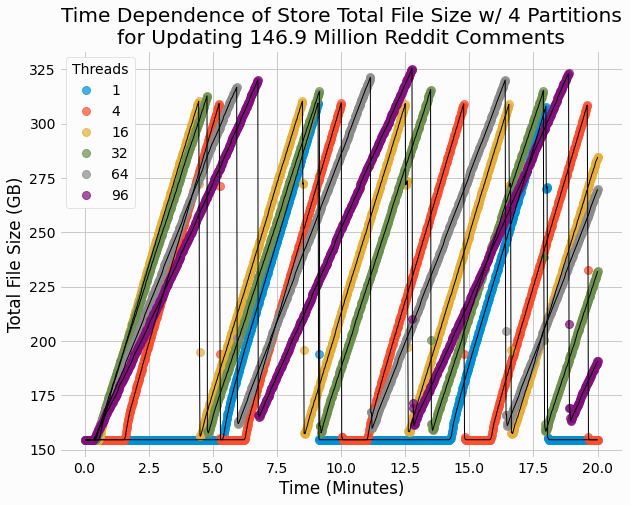

In [38]:
plt.figure(figsize=(9,7))

time_plot(update_results[(update_results['threads'].isin([1, 4, 16, 32, 64, 96])) &
                         (update_results['partitions'] == 4)]
          .sort_values('threads', ascending=True), 
          y_col='size', y_scale=1e-9, spline=False,
          label_func=lambda ix, row: str(row['threads']))

plt.ylabel('Total File Size (GB)')
plt.legend(loc='upper left', ncol=1, title='Threads', framealpha=1)
plt.xlabel('Time (Minutes)')
plt.title(f'Time Dependence of Store Total File Size w/ 4 Partitions'
          f'\nfor Updating {entries/1e6:.1f} Million Reddit Comments')
savefig('doc_update_time_dependence_size_threads')


<Figure size 648x504 with 0 Axes>

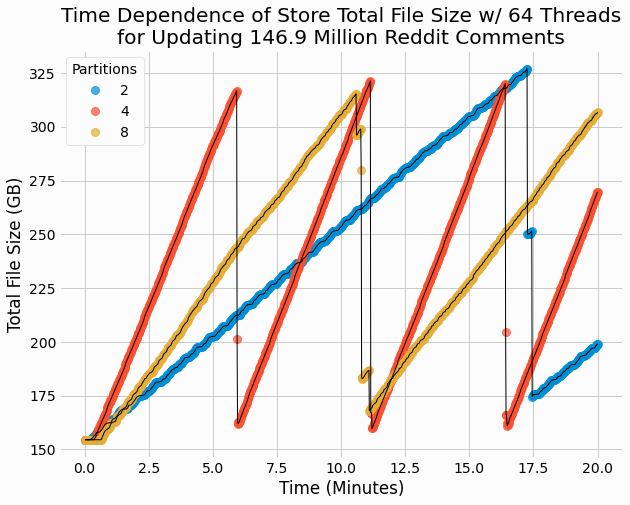

In [39]:

plt.figure(figsize=(9,7))

time_plot(update_results[(update_results['threads'] == 64)]
          .sort_values('partitions', ascending=True), 
          y_col='size', y_scale=1e-9, spline=False,
          label_func=lambda ix, row: str(row['partitions']))

plt.ylabel('Total File Size (GB)')
plt.legend(loc='upper left', ncol=1, title='Partitions', framealpha=1)
plt.xlabel('Time (Minutes)')
plt.title(f'Time Dependence of Store Total File Size w/ 64 Threads'
          f'\nfor Updating {entries/1e6:.1f} Million Reddit Comments')
savefig('doc_update_time_dependence_size_partitions')
